In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [25]:
import itertools
import warnings
import inspect
import math

import os

import numpy as np
import scipy as sp
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrow
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
#from matplotlib.backends.backend_pdf import PdfPages

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points
from src.transpositions import Transposition
from src import poset_scores

from tqdm.notebook import tqdm

tqdm.pandas()

# Height Model

In [3]:
def get_heights_stree(heights, triangles) -> gh.SimplexTree:
    # returns the SimplexTree coresponding the given heights vector and the triangulation
    heights = np.asarray(heights)
    stree = gh.SimplexTree()
    for triangle in triangles:
        for i in range(1, len(triangle) + 1):
            for simplex in itertools.combinations(triangle, r=i):
                value = max(heights[list(simplex)])
                stree.insert(simplex, value)
    return stree

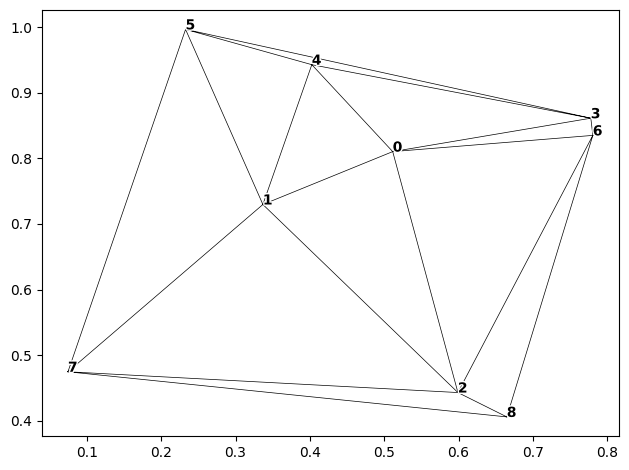

In [4]:
n = 9
points = np.random.random([n, 2])

complex_dimension = 2
points = np.random.random([n, complex_dimension])
#points[:2**complex_dimension] = np.array(list(itertools.product([0, 1], repeat=complex_dimension)))

simplices = np.array([tuple(s) for s, _ in gh.AlphaComplex(points).create_simplex_tree().get_simplices()], dtype=object)
simplices = simplices[np.argsort([len(s) for s in simplices])]
dims = np.vectorize(len)(simplices) - 1

triangles = simplices[dims == 2]

triang = tri.Triangulation(points[:, 0], points[:, 1], np.array(list(triangles)))

plt.triplot(triang, color='black', linewidth=0.5)
enumerate_points(points, weight='semibold', forewidth=2)

plt.tight_layout()
plt.show()

In [5]:
scores = [poset_scores.number_of_nodes, 
          poset_scores.number_of_maximal_nodes, 
          poset_scores.number_of_minimal_nodes, 
          poset_scores.width, 
          poset_scores.number_of_edges_in_reduction, 
          poset_scores.number_of_edges_in_closure, 
          poset_scores.height, 
          poset_scores.cycles_dimension]

df_dp_properties = pd.DataFrame()
df_dp_properties['heights'] = list(itertools.permutations(np.arange(n), n))
df_dp_properties['stree'] = df_dp_properties['heights'].progress_apply(lambda x: get_heights_stree(np.array(x), triangles))
df_dp_properties['dp'] = df_dp_properties['stree'].progress_apply(depth.DepthPoset.from_simplex_tree)

for score in scores:
    df_dp_properties[score.__name__] = df_dp_properties['dp'].progress_apply(score)

print(f'df_dp_properties.shape = {df_dp_properties.shape}')
df_dp_properties.sort_values([score.__name__ for score in scores], ascending=False).head()

  0%|          | 0/362880 [00:00<?, ?it/s]

  0%|          | 0/362880 [00:00<?, ?it/s]

  0%|          | 0/362880 [00:00<?, ?it/s]

  0%|          | 0/362880 [00:00<?, ?it/s]

  0%|          | 0/362880 [00:00<?, ?it/s]

  0%|          | 0/362880 [00:00<?, ?it/s]

  0%|          | 0/362880 [00:00<?, ?it/s]

  0%|          | 0/362880 [00:00<?, ?it/s]

  0%|          | 0/362880 [00:00<?, ?it/s]

  0%|          | 0/362880 [00:00<?, ?it/s]

df_dp_properties.shape = (362880, 11)


,heights,stree,dp,number_of_nodes,number_of_maximal_nodes,number_of_minimal_nodes,width,number_of_edges_in_reduction,number_of_edges_in_closure,height,cycles_dimension
8499,"(0, 2, 6, 7, 8, 1, 4, 5, 3)",<gudhi.simplex_tree.SimplexTree object at 0x7c...,<src.depth.DepthPoset object at 0x7c54771e2690>,4,4,4,4,0,0,0,0
8501,"(0, 2, 6, 7, 8, 1, 5, 4, 3)",<gudhi.simplex_tree.SimplexTree object at 0x7c...,<src.depth.DepthPoset object at 0x7c54771e1190>,4,4,4,4,0,0,0,0
8859,"(0, 2, 7, 3, 8, 1, 5, 6, 4)",<gudhi.simplex_tree.SimplexTree object at 0x7c...,<src.depth.DepthPoset object at 0x7c54770c6030>,4,4,4,4,0,0,0,0
8861,"(0, 2, 7, 3, 8, 1, 6, 5, 4)",<gudhi.simplex_tree.SimplexTree object at 0x7c...,<src.depth.DepthPoset object at 0x7c54770fa360>,4,4,4,4,0,0,0,0
8979,"(0, 2, 7, 4, 8, 1, 5, 6, 3)",<gudhi.simplex_tree.SimplexTree object at 0x7c...,<src.depth.DepthPoset object at 0x7c5476f47290>,4,4,4,4,0,0,0,0


In [20]:
df_dp_properties[['number_of_nodes', 'number_of_edges_in_reduction']].value_counts().sort_index(ascending=False).reset_index().pivot_table(index='number_of_nodes', columns='number_of_edges_in_reduction', values='count').fillna(0).astype(int)

number_of_edges_in_reduction,0,1,2
number_of_nodes,,,
0,44200,0,0
1,135768,0,0
2,157020,2508,0
3,15192,6992,0
4,620,484,96


In [21]:
df_dp_properties[['height', 'width']].value_counts().sort_index(ascending=False).reset_index()

,height,width,count
0,1,3,484
1,1,2,7088
2,1,1,2508
3,0,4,620
4,0,3,15192
5,0,2,157020
6,0,1,135768
7,0,0,44200


# Delauney Model

In [61]:
n = 4

points = np.random.random([n, 2])
simplices = np.array([tuple(s) for s, _ in gh.AlphaComplex(points).create_simplex_tree().get_simplices()], dtype=object)

simplices0 = simplices[np.vectorize(len)(simplices) == 1]
simplices1 = simplices[np.vectorize(len)(simplices) == 2]
simplices2 = simplices[np.vectorize(len)(simplices) == 3]
simplices = np.concatenate([simplices0, simplices1, simplices2])
n0 = len(simplices0)
n1 = len(simplices1)
n2 = len(simplices2)
for i, ni in enumerate([n0, n1, n2]):
    print(f'n{i}: {ni}')

filtrations = []
n_permutations = math.factorial(n0)*math.factorial(n1)*math.factorial(n2)
with tqdm(total=n_permutations, desc='geting orders') as pbar:
    for filtration0 in itertools.permutations(np.arange(n0)):
        for filtration1 in itertools.permutations(np.arange(n1)):
            for filtration2 in itertools.permutations(np.arange(n2)):
                filtrations.append(np.concatenate([filtration0, filtration1, filtration2]))
                pbar.update()
strees = []
with tqdm(total=n_permutations, desc='Defime  Simplicial Complexes') as pbar:
    for filtration in filtrations:
        strees.append(gh.SimplexTree())
        for simplex, value in zip(simplices, filtration):
            strees[-1].insert(simplex, value)
        pbar.update()

df_dps = pd.DataFrame(
    {
        'filtration': filtrations, 
        'stree': strees
    }
)
df_dps['dp'] = df_dps['stree'].progress_apply(DepthPoset.from_simplex_tree)
df_dps['dp0'] = df_dps['dp'].progress_apply(lambda dp: dp.subposet_dim(0))
df_dps['dp1'] = df_dps['dp'].progress_apply(lambda dp: dp.subposet_dim(1))

print(f'df_dps.shape = {df_dps.shape}')
df_dps.head()

n0: 4
n1: 6
n2: 3


geting orders:   0%|          | 0/103680 [00:00<?, ?it/s]

Defime  Simplicial Complexes:   0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

df_dps.shape = (103680, 5)


,filtration,stree,dp,dp0,dp1
0,"[0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 0, 1, 2]",<gudhi.simplex_tree.SimplexTree object at 0x77...,<src.depth.DepthPoset object at 0x77507d8f6630>,<src.depth.DepthPoset object at 0x775082d84b60>,<src.depth.DepthPoset object at 0x77508076bf80>
1,"[0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 0, 2, 1]",<gudhi.simplex_tree.SimplexTree object at 0x77...,<src.depth.DepthPoset object at 0x77507d8f7320>,<src.depth.DepthPoset object at 0x775082d60aa0>,<src.depth.DepthPoset object at 0x775080783560>
2,"[0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 1, 0, 2]",<gudhi.simplex_tree.SimplexTree object at 0x77...,<src.depth.DepthPoset object at 0x77507d8f6900>,<src.depth.DepthPoset object at 0x775085263440>,<src.depth.DepthPoset object at 0x7750807805f0>
3,"[0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 1, 2, 0]",<gudhi.simplex_tree.SimplexTree object at 0x77...,<src.depth.DepthPoset object at 0x77507d8f67e0>,<src.depth.DepthPoset object at 0x775082eacef0>,<src.depth.DepthPoset object at 0x775080597080>
4,"[0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 2, 0, 1]",<gudhi.simplex_tree.SimplexTree object at 0x77...,<src.depth.DepthPoset object at 0x77507d8f7830>,<src.depth.DepthPoset object at 0x775082e8dbb0>,<src.depth.DepthPoset object at 0x775080596e40>


In [62]:
scores = [poset_scores.number_of_nodes, 
          poset_scores.number_of_maximal_nodes, 
          poset_scores.number_of_minimal_nodes, 
          poset_scores.width, 
          poset_scores.number_of_edges_in_reduction, 
          poset_scores.number_of_edges_in_closure, 
          poset_scores.height, 
          poset_scores.cycles_dimension]

df_dp_properties = pd.DataFrame()

for col in ['dp0', 'dp1']:
    for score in scores:
        df_dp_properties[(col, score.__name__)] = df_dps[col].progress_apply(score)
df_dp_properties.columns = pd.MultiIndex.from_tuples(df_dp_properties.columns)

print(f'df_dp_properties.shape = {df_dp_properties.shape}')
df_dp_properties.head()

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

  0%|          | 0/103680 [00:00<?, ?it/s]

df_dp_properties.shape = (103680, 16)


dp0                                                        \
  number_of_nodes number_of_maximal_nodes number_of_minimal_nodes width   
0               0                       0                       0     0   
1               0                       0                       0     0   
2               0                       0                       0     0   
3               0                       0                       0     0   
4               0                       0                       0     0   

                                                                  \
  number_of_edges_in_reduction number_of_edges_in_closure height   
0                            0                          0      0   
1                            0                          0      0   
2                            0                          0      0   
3                            0                          0      0   
4                            0                          0      0   

                               dp1                          \
  cycles_dimension number_of_nodes number_of_maximal_nodes   
0                0               0                       0   
1                0               0                       0   
2                0               0                       0   
3                0               0                       0   
4                0               1                       1   

                                                              \
  number_of_minimal_nodes width number_of_edges_in_reduction   
0                       0     0                            0   
1                       0     0                            0   
2                       0     0                            0   
3                       0     0                            0   
4                       1     1                            0   

                                                      
  number_of_edges_in_closure height cycles_dimension  
0                          0      0                0  
1                          0      0                0  
2                          0      0                0  
3                          0      0                0  
4                          0      0                0

In [63]:
df_dp_properties['dp0'][['number_of_nodes', 'number_of_edges_in_reduction']].value_counts()

number_of_nodes  number_of_edges_in_reduction
0                0                               90720
1                0                               12960
Name: count, dtype: int64

In [64]:
df_dp_properties['dp1'][['number_of_nodes', 'number_of_edges_in_reduction']].value_counts()

number_of_nodes  number_of_edges_in_reduction
0                0                               69120
1                0                               34560
Name: count, dtype: int64

dp0                                                        \
       number_of_nodes number_of_maximal_nodes number_of_minimal_nodes width   
0                    0                       0                       0     0   
1                    0                       0                       0     0   
2                    0                       0                       0     0   
3                    0                       0                       0     0   
4                    0                       0                       0     0   
...                ...                     ...                     ...   ...   
103675               0                       0                       0     0   
103676               0                       0                       0     0   
103677               0                       0                       0     0   
103678               0                       0                       0     0   
103679               0                       0                       0     0   

                                                                       \
       number_of_edges_in_reduction number_of_edges_in_closure height   
0                                 0                          0      0   
1                                 0                          0      0   
2                                 0                          0      0   
3                                 0                          0      0   
4                                 0                          0      0   
...                             ...                        ...    ...   
103675                            0                          0      0   
103676                            0                          0      0   
103677                            0                          0      0   
103678                            0                          0      0   
103679                            0                          0      0   

                                    dp1                          \
       cycles_dimension number_of_nodes number_of_maximal_nodes   
0                     0               0                       0   
1                     0               0                       0   
2                     0               0                       0   
3                     0               0                       0   
4                     0               1                       1   
...                 ...             ...                     ...   
103675                0               0                       0   
103676                0               1                       1   
103677                0               0                       0   
103678                0               0                       0   
103679                0               0                       0   

                                                                   \
       number_of_minimal_nodes width number_of_edges_in_reduction   
0                            0     0                            0   
1                            0     0                            0   
2                            0     0                            0   
3                            0     0                            0   
4                            1     1                            0   
...                        ...   ...                          ...   
103675                       0     0                            0   
103676                       1     1                            0   
103677                       0     0                            0   
103678                       0     0                            0   
103679                       0     0                            0   

                                                           
       number_of_edges_in_closure height cycles_dimension  
0                               0      0                0  
1                               0      0                0  
2                 